In [1]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)
%cd gdrive
%cd MyDrive
%cd Colab Notebooks
%cd Impact-of-COVID19-and-WinterStorm
!pip install adtk > /dev/null 2>&1

Mounted at /content/gdrive/
/content/gdrive
/content/gdrive/MyDrive
/content/gdrive/MyDrive/Colab Notebooks
/content/gdrive/MyDrive/Colab Notebooks/Impact-of-COVID19-and-WinterStorm


In [2]:
import os
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
import seaborn as sns
import sklearn
from sklearn.linear_model import LinearRegression
%matplotlib inline
import missingno as msno
np.random.seed(19)
from matplotlib.pyplot import figure
from datetime import datetime 
from Graphs import load_data,load_graph_kwh,yearly_graph_kwh,load_graph_count,monthly_graph_kwh,daily_graph_kwh
from Graphs import load_graph_kwh_and_count,yearly_graph_kwh_and_count,monthly_graph_kwh_and_count,daily_graph_kwh_and_count
from agg_and_heatmap_functions import length,prav3,prav2,prav1,dinostorm,plot_aggraph,heatmap,finalheatmap
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, SGDRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.utils import resample
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Ridge,Lasso
from sklearn.model_selection import GridSearchCV,KFold
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
weather_daily=pd.read_csv('Austin_weather_daily.csv')
weather_daily['time']=pd.to_datetime(weather_daily['time'],utc=False)
weather_daily1=weather_daily.set_index('time',drop=True)
weather_austin_daily=weather_daily1['tavg']
# NOT UTC TIME
weather_Pred=pd.read_csv('Austin_hourly.csv')
weather_Pred['time']=pd.to_datetime(weather_Pred['time'])
weather_pred1=weather_Pred.set_index('time',drop=True)
weather_austin_hourl_pred=weather_pred1['temp']
from sklearn.preprocessing import MinMaxScaler
from adtk.data import validate_series
from adtk.visualization import plot
from adtk.detector import SeasonalAD
from adtk.data import to_events

from adtk.detector import OutlierDetector
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import torch
import time
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset


In [4]:
id_list = pd.read_csv('buildingInfo.csv')

#id_list.drop('Unnamed: 0',axis=1,inplace=True)
id_list['buildingType'].unique()
res_type = ['SINGLE FAMILY', 'MULTIFAMILY',  'FOURPLEX', 
            'DUPLEX', 'CONDOS', 'CONDO (STACKED)', 
            '1 FAM DWELLING, ACCESSORY DWELLING UNIT',
            'TOWNHOMES','MOHO SINGLE PP', 
            '1 FAM DWELLING, GARAGE APARTMENT', 'MOHO DOUBLE PP',
            'MOHO SINGLE REAL', 'MOHO DOUBLE REAL', 'TRIPLEX', 
            '1 FAM DWELLING, MOHO DOUBLE REAL',
           '1 FAM DWELLING, MOHO SINGLE REAL']
res_type_id_list = id_list[id_list['buildingType'].isin(res_type)].copy()


In [5]:
single_Famiy=res_type_id_list[res_type_id_list['buildingType']=='SINGLE FAMILY']
single_Famiy[single_Famiy['zipCode']==78758]

,Service Point,zipCode,rate,buildingType,meterCount,squareFt
29,-1583,78758,E-SEC2,SINGLE FAMILY,14,7042.125
30,-1582,78758,E-SEC1,SINGLE FAMILY,25,19913.375
31,-1581,78758,E-RES,SINGLE FAMILY,5363,8224307.500


In [6]:
def prepare_data(service_point):
    sample=load_data(service_point)
    sample=sample.set_index(sample[sample.columns[0]])
    sample=sample[sample.columns[1:2]]
    sample=sample.resample('D').sum()
    return sample
def make_features(dataframe,time_level):
    s=dataframe
    start_time=s.index[0]
    end_time=s.index[-1]
    example_ts=s
    example_ts['dayofyear_cos']=np.cos(example_ts.index.dayofyear*(2.*np.pi/365))
    example_ts['dayofyear_sim']=np.sin(example_ts.index.dayofyear*(2.*np.pi/365))
    example_ts['month_cos']=np.cos(example_ts.index.month*(2.*np.pi/12))
    example_ts['month_sin']=np.sin(example_ts.index.month*(2.*np.pi/12))
    example_ts['year'] = example_ts.index.year

    for ts in example_ts.index:
        if time_level=='hourly':
             example_ts.loc[ts:ts, 'TMP'] = weather_austin_hourl_pred[weather_austin_hourl_pred.index == ts] 
        else:
             example_ts.loc[ts:ts, 'TMP'] = weather_austin_hourl_pred[weather_austin_hourl_pred.index == ts]

    return example_ts

In [7]:
def clean_data(data,servicepoint):
    data = data.rename(columns={list(data.columns.values)[0]: 'Energy_kwh'})
    data1=data[:'2021-02-10']
    bad_value=data1[data1.columns[0]].quantile(0.98)
    print('filter_value',bad_value)
    Index=data1[data1['Energy_kwh']>bad_value].index
    data1=data1.drop(Index)
    return pd.concat([data1,data['2021-02-11':'2021-02-22']])
def preprocess_data(servicepoint,df):
    s=df
    s = s.rename(columns={list(s.columns.values)[0]: 'Energy_kwh'})
    train_set=s['2018-01-01':'2021-02-10']
    test_set=s['2021-02-11':'2021-02-19']
    residential_train=make_features(train_set,'daily')
    residential_test=make_features(test_set,'daily')
    Q1=residential_train[residential_train.columns[0]].quantile(0.25)
    Q3=residential_train[residential_train.columns[0]].quantile(0.75)
    low_5=residential_train[residential_train['TMP']<=5]['Energy_kwh'].quantile(0.50)
    lower_bound=low_5
    IQR=Q3-Q1
    upper_bound=Q3+1.5*IQR
    Index=residential_train[(residential_train['Energy_kwh'] <Q1 ) & (residential_train['TMP'] <0) ].index
    print('dropped_points',len(Index))
    cleaned_train=residential_train.drop(Index,axis=0)
    cleaned_train1=pd.concat([cleaned_train,residential_test])
    return cleaned_train1

In [159]:
def prediction_model(service_point,df,visualize=True,calculate_metrics=None,metric=None,boostrap=None):
    print('.....LOADING DATA.........')
    q=preprocess_data(service_point,df)
    if boostrap==True:
      def bootstrap_sample(data):
        return data.sample(frac=1, replace=True,random_state=567)
      temp_5=q[q['TMP']<=0][:'2020-01-01']
      n_samples = 5
      bootstrapped_data = [bootstrap_sample(temp_5) for i in range(n_samples)]
      bootstrapped_data = pd.concat(bootstrapped_data, axis=0)
      q1=pd.concat([q,bootstrapped_data])
      train_below_5=q1[q1['TMP']<=5][:'2020-01-01']
      train_above_5=q1[q1['TMP']>5][:'2020-01-01']
    else:
        train_below_5=q[q['TMP']<=5][:'2020-01-01']
        train_above_5=q[q['TMP']>5][:'2020-01-01']

    
    m_below,b_below = np.polyfit(train_below_5['TMP'], train_below_5['Energy_kwh'], 1)
    if visualize:
        plt.scatter(train_below_5['TMP'], train_below_5['Energy_kwh'])
        plt.plot(train_below_5['TMP'], m_below*train_below_5['TMP'] +b_below,color='red')
        plt.show()
        corr_check=train_below_5['TMP'].corr(train_below_5['Energy_kwh'])
        print(train_below_5['TMP'].corr(train_below_5['Energy_kwh']))

    m_above,m1_above,b_above = np.polyfit(train_above_5['TMP'], train_above_5['Energy_kwh'], 2)
    if visualize:
        plt.scatter(train_above_5['TMP'], train_above_5['Energy_kwh'])
        plt.plot(train_above_5['TMP'], m_above*train_above_5['TMP']**2 + m1_above*train_above_5['TMP'] + b_above,color='red')
        plt.show()
        print(train_above_5['TMP'].corr(train_above_5['Energy_kwh']))
    
        print('...............VIZ DONE.............')
    
    test_below_5=q[q['TMP']<=5]['2020-01-01':]
    test_above_5=q[q['TMP']>5]['2020-01-01':]

    #SCALING 
    print('...........STARTED SCALING')
    scaler_below = MinMaxScaler()
    scaler_pred_below=MinMaxScaler()
    scaler_pred_below.fit(train_below_5[['Energy_kwh']])
    
    train_below_5_scaled = scaler_below.fit_transform(train_below_5.to_numpy())
    train_below_5_scaled = pd.DataFrame(train_below_5_scaled, columns=train_below_5.columns,index=train_below_5.index)
    
    test_below_5_scaled = scaler_below.transform(test_below_5.to_numpy())
    test_below_5_scaled = pd.DataFrame(test_below_5_scaled, columns=test_below_5.columns,index=test_below_5.index)
    
    scaler_above = MinMaxScaler()
    scaler_pred_above=MinMaxScaler()
    scaler_pred_above.fit(train_above_5[['Energy_kwh']])
    
    train_above_5_scaled = scaler_above.fit_transform(train_above_5.to_numpy())
    train_above_5_scaled = pd.DataFrame(train_above_5_scaled, columns=train_above_5.columns,index=train_above_5.index)
    
    test_above_5_scaled = scaler_above.transform(test_above_5.to_numpy())
    test_above_5_scaled = pd.DataFrame(test_above_5_scaled, columns=test_above_5.columns,index=test_above_5.index)
    
    print('..........SCALING DONE.........')
    
    ## FITTING
    lr_below_5_score_model=LinearRegression()
    X5_train, X5_test, y5_train, y5_test = train_test_split(train_below_5_scaled[['year','TMP']], train_below_5_scaled[['Energy_kwh']], test_size=0.2, random_state=42)
    lr_below_5_score_model.fit(X5_train,y5_train)
    print(' holdout_score_for below 5',lr_below_5_score_model.score(X5_test,y5_test))
    Lr_below_5=LinearRegression().fit(train_below_5_scaled[['year','TMP']], train_below_5_scaled[['Energy_kwh']])
    cv_score_below_5=cross_val_score(LinearRegression(), train_below_5_scaled[['year','TMP']], train_below_5_scaled[['Energy_kwh']], cv=5, scoring='r2')
    print('cv_score_below_5',cv_score_below_5)
    if corr_check and lr_below_5_score_model.score(X5_test,y5_test)<0.3:
      if boostrap==True:
        raise Exception("data and model is not good, ignore this servicepoint")
    rf_model=RandomForestRegressor()
    X_train, X_test, y_train, y_test = train_test_split(train_above_5_scaled[train_above_5_scaled.columns[1:]], train_above_5_scaled[['Energy_kwh']], test_size=0.2, random_state=42)
    rf_model.fit(X_train,y_train)
    print(' holdout_score_for above 5',rf_model.score(X_test,y_test))
    final_rf=RandomForestRegressor()
    final_rf.fit(train_above_5_scaled[train_above_5_scaled.columns[1:]], train_above_5_scaled[['Energy_kwh']])
    cv_score_above_5=cross_val_score(RandomForestRegressor(), train_above_5_scaled[train_above_5_scaled.columns[1:]], train_above_5_scaled[['Energy_kwh']], cv=5, scoring='r2')
    print('cv_score_above_5',cv_score_above_5)
    ## PREDICTION
    below_5_predictions_sc=scaler_pred_below.inverse_transform(np.array(Lr_below_5.predict(test_below_5_scaled[['year','TMP']])).reshape(-1,1))
    
    below_5_predictions=pd.DataFrame(below_5_predictions_sc,
                                     index=test_below_5_scaled.index)
    
    test_below_5_scaled2=pd.DataFrame(scaler_below.inverse_transform(test_below_5_scaled),columns=test_below_5_scaled.columns,
                                      index=test_below_5_scaled.index)
    below_5_predictions1=test_below_5_scaled2.merge(below_5_predictions,how='inner',left_index=True,right_index=True)
        
        
    
    test_rf_features = test_above_5_scaled[test_above_5_scaled.columns[1:]]
    above_5_predictions_sc=scaler_pred_above.inverse_transform(np.array(final_rf.predict(test_rf_features)).reshape(-1,1))

    above_5_predictions=pd.DataFrame(above_5_predictions_sc,
                                     index=test_above_5_scaled.index)
    test_above_5_scaled2=pd.DataFrame(scaler_above.inverse_transform(test_above_5_scaled),columns=test_above_5_scaled.columns,
                                      index=test_above_5_scaled.index)
    
    above_5_predictions1=test_above_5_scaled2.merge(above_5_predictions,how='inner',left_index=True,right_index=True)
    
    ## JOINING EVERYTHING AND CONVERTING BACK
    total_predictions=pd.concat([above_5_predictions1,below_5_predictions1])[['Energy_kwh','TMP',0]]
    total_predictions1=total_predictions[total_predictions[0]>0].sort_index().rename(
                                                            columns={0: 'prediction'})
    total_predictions1['difference']=total_predictions1['prediction']-total_predictions1['Energy_kwh']
    total_predictions2=total_predictions1[['Energy_kwh','prediction','difference']].resample('D').sum()
    for ts in total_predictions2.index:
      total_predictions2.loc[ts:ts, 'TMP'] = weather_austin_daily[weather_austin_daily.index == ts] 

    
    if calculate_metrics and metric:
        predic=total_predictions1['prediction']['2021-02-11':'2021-02-19']
        real=  total_predictions1['Energy_kwh']['2021-02-11':'2021-02-19']
        if metric=='perc_diff':
            result=100*(predic-real)/real
        elif metric=='difference(z_score)':
            metric_result=predic-real
            result=(metric_result-metric_result.mean())/metric_result.std()
        elif metric=='perc_diff(reverse)':
            result=100*(real-predic)/predic
        di=pd.DataFrame(result)
        di['timestamp']=di.index
        di1=di.rename(columns={0:service_point})
        return di1.reset_index().iloc[:,1:].set_index('timestamp',drop=True)
    else:
        return total_predictions2

filter_value 209.89498207092277
.....LOADING DATA.........
dropped_points 18


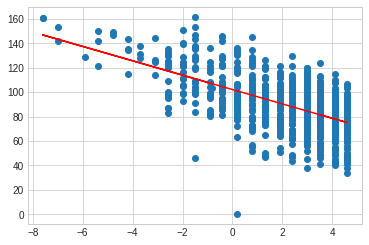

-0.5911258718429021


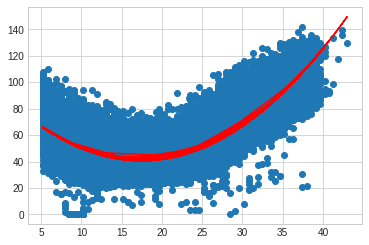

0.5002448344438923
...............VIZ DONE.............
...........STARTED SCALING
..........SCALING DONE.........
 holdout_score_for below 5 0.2781813488580258
cv_score_below_5 [ 0.39881254  0.16736611 -0.05507573  0.30506861 -0.51959461]
 holdout_score_for above 5 0.5831482192011426
cv_score_above_5 [0.34387994 0.44040483 0.07531087 0.51687292 0.57768295]


,Energy_kwh,prediction,difference,TMP
-1583 kWh DateTime,,,,
2021-02-10,1921.707199,873.228555,-1048.478644,5.2
2021-02-11,6726.203194,2209.553557,-4516.649637,0.8
2021-02-12,7226.377350,2497.420665,-4728.956685,-0.6
2021-02-13,7238.172173,2669.202870,-4568.969302,-1.6
2021-02-14,7671.822403,2785.874061,-4885.948342,-4.3
2021-02-15,7038.653778,3689.342929,-3349.310849,-9.0
2021-02-16,5502.928398,3648.889099,-1854.039299,-7.6
2021-02-17,5782.335770,2770.044301,-3012.291468,-1.8
2021-02-18,6769.274239,2713.174425,-4056.099814,-1.8


In [160]:
servicepoint=1583
df=pd.read_csv(f'{servicepoint}.csv')
df[df.columns[0]]=pd.to_datetime(df[df.columns[0]])
df1=df.set_index(f'{-servicepoint} kWh DateTime',drop=True)['2018':].resample('H').sum()
df2=clean_data(df1,servicepoint)
df3=prediction_model(-servicepoint,df2,visualize=True,calculate_metrics=None,metric=None,boostrap=False)
df3['2021-02-10':]

filter_value 209.89498207092277
.....LOADING DATA.........
dropped_points 18


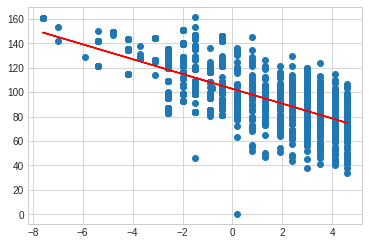

-0.6669815794684905


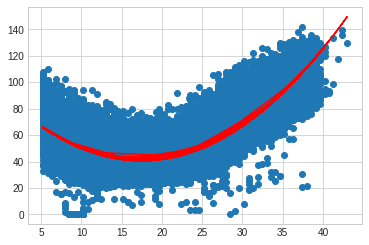

0.5002448344438923
...............VIZ DONE.............
...........STARTED SCALING
..........SCALING DONE.........
 holdout_score_for below 5 0.45868990165312673
cv_score_below_5 [0.40862613 0.03230545 0.4149096  0.15790745 0.14907202]
 holdout_score_for above 5 0.5823690002692201
cv_score_above_5 [0.33228403 0.44985168 0.06007899 0.51745655 0.58109695]


,Energy_kwh,prediction,difference,TMP
-1583 kWh DateTime,,,,
2021-02-10,1921.707199,871.712254,-1049.994945,5.2
2021-02-11,6726.203194,2270.228013,-4455.975180,0.8
2021-02-12,7226.377350,2570.021686,-4656.355664,-0.6
2021-02-13,7238.172173,2748.920965,-4489.251208,-1.6
2021-02-14,7671.822403,2870.425936,-4801.396467,-4.3
2021-02-15,7038.653778,3811.326239,-3227.327539,-9.0
2021-02-16,5502.928398,3769.196375,-1733.732023,-7.6
2021-02-17,5782.335770,2853.940337,-2928.395433,-1.8
2021-02-18,6769.274239,2794.714295,-3974.559943,-1.8


In [153]:
servicepoint=1583
df=pd.read_csv(f'{servicepoint}.csv')
df[df.columns[0]]=pd.to_datetime(df[df.columns[0]])
df1=df.set_index(f'{-servicepoint} kWh DateTime',drop=True)['2018':].resample('H').sum()
df2=clean_data(df1,servicepoint)
df3=prediction_model(-servicepoint,df2,visualize=True,calculate_metrics=None,metric=None,boostrap=True)
df3['2021-02-10':]

416


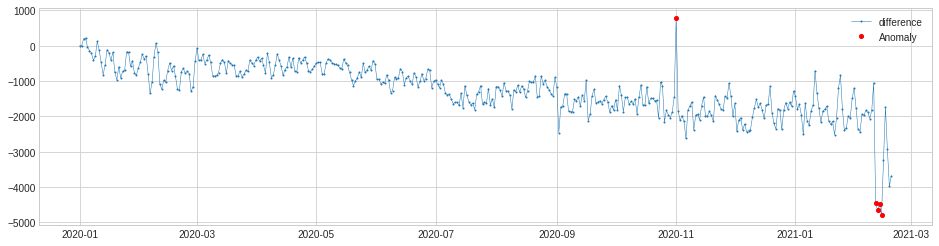

In [154]:
new_diff = df3[['difference']].resample('D').ffill()
print(len(new_diff))
s_train = validate_series(new_diff)
outlier_detector = OutlierDetector(LocalOutlierFactor(contamination=0.01))
anomalies = outlier_detector.fit_detect(s_train)
plot(s_train, anomaly=anomalies, anomaly_color="red", anomaly_tag="marker")

In [156]:
df3.merge(pd.DataFrame(anomalies),left_index=True,right_index=True)['2021-02':]

,Energy_kwh,prediction,difference,TMP,0
-1583 kWh DateTime,,,,,
2021-02-01,2944.501785,1175.146712,-1769.355073,11.7,False
2021-02-02,3538.240211,1180.081353,-2358.158858,12.1,False
2021-02-03,3631.392002,1197.490697,-2433.901305,15.7,False
2021-02-04,3018.826389,1077.803953,-1941.022436,20.0,False
2021-02-05,3174.624008,1201.553697,-1973.070312,11.4,False
2021-02-06,3222.816610,1388.568878,-1834.247732,14.6,False
2021-02-07,3290.878803,1406.639720,-1884.239083,12.9,False
2021-02-08,3386.697992,1325.644282,-2061.053710,16.2,False
2021-02-09,3281.089010,1449.484203,-1831.604808,14.1,False
